<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/clear_latent_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set Dataset and model

In [ ]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision import utils
from torchvision.utils import save_image
from skimage.metrics import structural_similarity as ssim
import math
import time
from torchsummary import summary
import os
import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:
def save_checkpoint(epoch, model, optimizer, path): 
    state = { 'Epoch': epoch,
             'State_dict': model.state_dict(),
             'optimizer': optimizer.state_dict() 
             }
    torch.save(state, path)

In [ ]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
    else:
        device = 'cpu'
    return device

In [ ]:
# Define Loss function
def mse_loss(input, target):
    r = input[:,0:1,:,:] - target[:,0:1,:,:]
    g = (input[:,1:2,:,:] - target[:,1:2,:,:])
    b = input[:,2:3,:,:] - target[:,2:3,:,:]
    
    r = torch.mean(r**2)
    g = torch.mean(g**2)
    b = torch.mean(b**2)
    
    mean = (r + g + b)/3
   
    return mean

In [ ]:
def Get_psnr(input, output, max_val=1.0):
    """
    Remark    
    input type : tensor
    output type : float
    """
    input = input.cpu().clone().detach().numpy()
    output = output.cpu().clone().detach().numpy()

    b = input[:,:,0]
    g = input[:,:,1]
    r = input[:,:,2]

    hat_b = output[:,:,0]
    hat_g = output[:,:,1]
    hat_r = output[:,:,2]

    b_img_diff = hat_b - b
    g_img_diff = hat_g - g 
    r_img_diff = hat_r - r
    
    b_mse = np.mean(b_img_diff**2)
    g_mse = np.mean(g_img_diff**2)
    r_mse = np.mean(r_img_diff**2)

    total_mse = r_mse + g_mse + b_mse
    

    if total_mse == 0:
      return 100
    else:
      psnr = 10 * math.log10( (max_val**2)/total_mse)
      return psnr 

In [ ]:
batch_size = 2048
torch.manual_seed(1)
torch.cuda.manual_seed(1)

##Original Train/Validation/Test dataset

In [ ]:
org_tr_set = datasets.STL10(root = "./data", split = "unlabeled", transform = transforms.ToTensor(), download=True)
tr_subset, val_subset = torch.utils.data.random_split(org_tr_set,[80000,20000],generator=torch.Generator().manual_seed(1))
test_set = datasets.STL10(root = "./data", split = "test",transform = transforms.ToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
tr_dataloader = DataLoader(tr_subset, batch_size = batch_size, num_workers = 2, pin_memory=True)

val_dataloader = DataLoader(val_subset, batch_size = batch_size, num_workers = 2, pin_memory=True)

test_dataloader = DataLoader(test_set, batch_size = batch_size, num_workers = 2, pin_memory=True)


In [ ]:
print(len(tr_subset),len(val_subset), len(test_set))

80000 20000 8000


# Model. Setting parameter -> float

In [ ]:
class Autoencoder(nn.Module): # 잠재벡터 크기 설정(하드 코딩)
  def __init__(self):
    super(Autoencoder, self).__init__()
    latent_dim = 256
    latent_img_size_reduce_2 = 3

    self.encoder = nn.Sequential(
    # 96 by 96 by 3
        nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(32),
    # 48 by 48 by 32
        nn.ReLU(True),
  


        nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 2, stride = 2, padding = 0),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
    # 24 by 24 by 64  

        nn.Conv2d(in_channels =64, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
    # 12 by 12 by 128 
        nn.BatchNorm2d(128),
        nn.ReLU(True),


        nn.Conv2d(in_channels = 128, out_channels = 256,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(256),
    # 6 by 6 by 256
        nn.ReLU(True),

        nn.Conv2d(in_channels = 256, out_channels = latent_dim,  kernel_size = latent_img_size_reduce_2, stride = 1, padding=0), # latent_vector Z
        nn.BatchNorm2d(latent_dim),
        nn.ReLU(True),       
    )
    self.decoder = nn.Sequential(
    # 6 by 6 by 256

        nn.ConvTranspose2d(in_channels = latent_dim, out_channels = 256,  kernel_size = latent_img_size_reduce_2, stride = 1, padding=0),
        nn.BatchNorm2d(256),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels = 256, out_channels = 128,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(128),
        nn.ReLU(True),

    # 12 by 12 by 128  
        
        nn.ConvTranspose2d(in_channels = 128, out_channels = 64,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(64),
        nn.ReLU(True),


    # 24 by 24 by 64
        nn.ConvTranspose2d(in_channels = 64, out_channels = 32,  kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(32),
        nn.ReLU(True),   
    
    # 48 by 48 by 32

        nn.ConvTranspose2d(in_channels = 32, out_channels = 3, kernel_size = 2, stride = 2, padding=0),
        nn.BatchNorm2d(3),

    # 96 by 96 by 3
        nn.Sigmoid())
  
  def forward(self, x):
        latent_vector = self.encoder(x)
        decoded = self.decoder(latent_vector)
        return decoded

cuda
Epoch : [1/50] 

Training Loss: 0.059034	 validation Loss 0.044322
PNSR :9.57 	 SSIM : 0.43
PNSR :8.34 	 SSIM : 0.35
PNSR :6.22 	 SSIM : 0.34
PNSR :14.00 	 SSIM : 0.49
PNSR :12.58 	 SSIM : 0.47


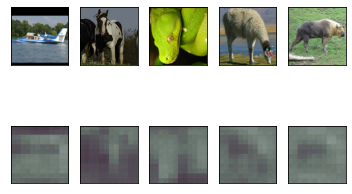

Epoch : [2/50] 

Training Loss: 0.027261	 validation Loss 0.037486
PNSR :10.13 	 SSIM : 0.46
PNSR :8.31 	 SSIM : 0.37
PNSR :7.56 	 SSIM : 0.37
PNSR :15.11 	 SSIM : 0.53
PNSR :13.06 	 SSIM : 0.48


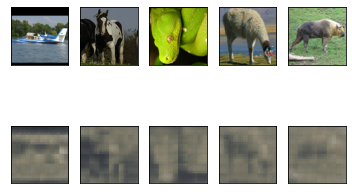

Epoch : [3/50] 

Training Loss: 0.019814	 validation Loss 0.025130
PNSR :12.18 	 SSIM : 0.52
PNSR :10.09 	 SSIM : 0.43
PNSR :9.60 	 SSIM : 0.39
PNSR :16.32 	 SSIM : 0.58
PNSR :14.62 	 SSIM : 0.53


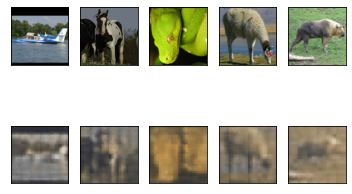

Epoch : [4/50] 

Training Loss: 0.015755	 validation Loss 0.020405
PNSR :12.42 	 SSIM : 0.58
PNSR :9.23 	 SSIM : 0.48
PNSR :10.41 	 SSIM : 0.44
PNSR :17.05 	 SSIM : 0.62
PNSR :15.35 	 SSIM : 0.57


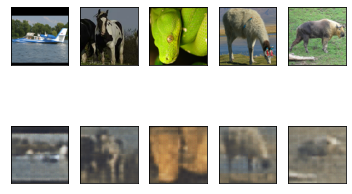

Epoch : [5/50] 

Training Loss: 0.013598	 validation Loss 0.016290
PNSR :13.69 	 SSIM : 0.61
PNSR :10.93 	 SSIM : 0.53
PNSR :11.10 	 SSIM : 0.46
PNSR :18.17 	 SSIM : 0.65
PNSR :15.77 	 SSIM : 0.60


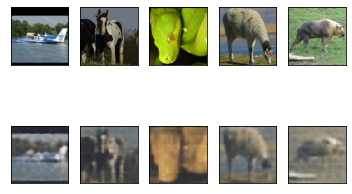

Epoch : [6/50] 

Training Loss: 0.011952	 validation Loss 0.015774
PNSR :14.02 	 SSIM : 0.63
PNSR :10.23 	 SSIM : 0.53
PNSR :10.83 	 SSIM : 0.44
PNSR :18.41 	 SSIM : 0.66
PNSR :16.31 	 SSIM : 0.62


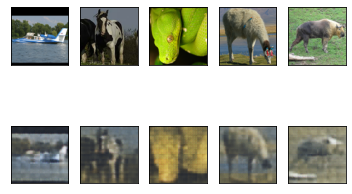

Epoch : [7/50] 

Training Loss: 0.010621	 validation Loss 0.013741
PNSR :14.51 	 SSIM : 0.66
PNSR :11.23 	 SSIM : 0.59
PNSR :11.45 	 SSIM : 0.44
PNSR :18.56 	 SSIM : 0.69
PNSR :16.77 	 SSIM : 0.63


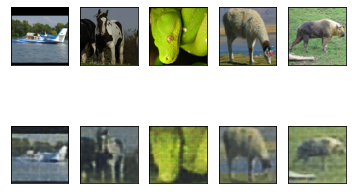

Epoch : [8/50] 

Training Loss: 0.009526	 validation Loss 0.012051
PNSR :14.65 	 SSIM : 0.66
PNSR :12.70 	 SSIM : 0.62
PNSR :12.39 	 SSIM : 0.50
PNSR :18.63 	 SSIM : 0.70
PNSR :17.29 	 SSIM : 0.65


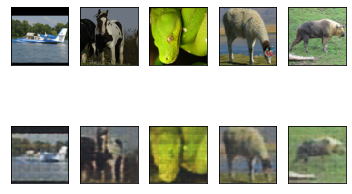

Epoch : [9/50] 

Training Loss: 0.008710	 validation Loss 0.011939
PNSR :14.68 	 SSIM : 0.67
PNSR :11.93 	 SSIM : 0.61
PNSR :12.23 	 SSIM : 0.49
PNSR :19.72 	 SSIM : 0.72
PNSR :17.79 	 SSIM : 0.65


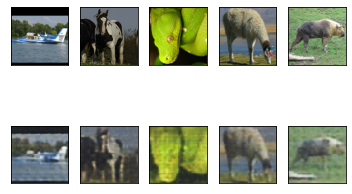

Epoch : [10/50] 

Training Loss: 0.008248	 validation Loss 0.010143
PNSR :15.36 	 SSIM : 0.69
PNSR :12.62 	 SSIM : 0.64
PNSR :13.00 	 SSIM : 0.52
PNSR :20.07 	 SSIM : 0.74
PNSR :17.91 	 SSIM : 0.67


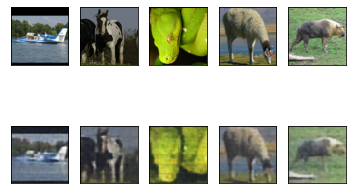

Epoch : [11/50] 

Training Loss: 0.007737	 validation Loss 0.009622
PNSR :17.02 	 SSIM : 0.70
PNSR :13.27 	 SSIM : 0.64
PNSR :14.38 	 SSIM : 0.53
PNSR :20.33 	 SSIM : 0.75
PNSR :18.20 	 SSIM : 0.68


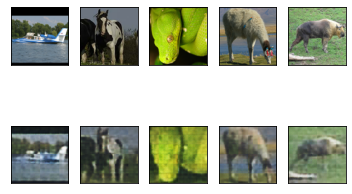

Epoch : [12/50] 

Training Loss: 0.007289	 validation Loss 0.008872
PNSR :17.11 	 SSIM : 0.70
PNSR :13.98 	 SSIM : 0.66
PNSR :16.05 	 SSIM : 0.54
PNSR :20.66 	 SSIM : 0.76
PNSR :18.05 	 SSIM : 0.69


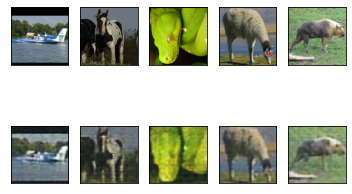

Epoch : [13/50] 

Training Loss: 0.007041	 validation Loss 0.009395
PNSR :17.41 	 SSIM : 0.68
PNSR :14.33 	 SSIM : 0.65
PNSR :15.05 	 SSIM : 0.52
PNSR :19.48 	 SSIM : 0.74
PNSR :18.01 	 SSIM : 0.68


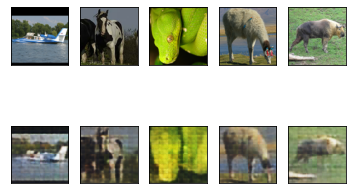

Epoch : [14/50] 

Training Loss: 0.006604	 validation Loss 0.010594
PNSR :15.96 	 SSIM : 0.69
PNSR :14.29 	 SSIM : 0.65
PNSR :13.99 	 SSIM : 0.53
PNSR :19.80 	 SSIM : 0.74
PNSR :17.63 	 SSIM : 0.68


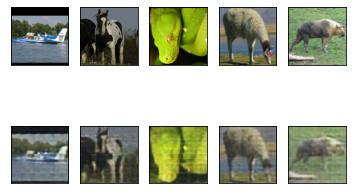

Epoch : [15/50] 

Training Loss: 0.007498	 validation Loss 0.007301
PNSR :17.64 	 SSIM : 0.73
PNSR :14.96 	 SSIM : 0.71
PNSR :16.81 	 SSIM : 0.58
PNSR :20.99 	 SSIM : 0.78
PNSR :18.48 	 SSIM : 0.71


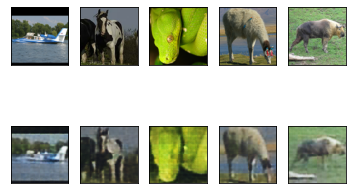

Epoch : [16/50] 

Training Loss: 0.006132	 validation Loss 0.009755
PNSR :16.60 	 SSIM : 0.70
PNSR :13.88 	 SSIM : 0.65
PNSR :16.30 	 SSIM : 0.54
PNSR :18.45 	 SSIM : 0.74
PNSR :16.93 	 SSIM : 0.68


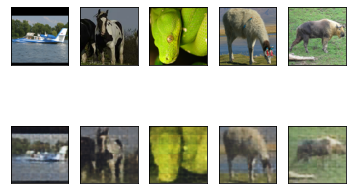

Epoch : [17/50] 

Training Loss: 0.006161	 validation Loss 0.010163
PNSR :15.69 	 SSIM : 0.70
PNSR :13.55 	 SSIM : 0.62
PNSR :15.57 	 SSIM : 0.55
PNSR :18.99 	 SSIM : 0.75
PNSR :17.29 	 SSIM : 0.69


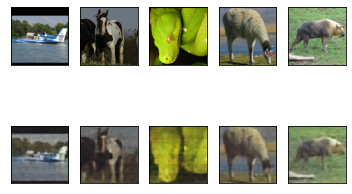

Epoch : [18/50] 

Training Loss: 0.006148	 validation Loss 0.007403
PNSR :18.37 	 SSIM : 0.74
PNSR :15.41 	 SSIM : 0.72
PNSR :16.55 	 SSIM : 0.57
PNSR :21.03 	 SSIM : 0.78
PNSR :18.84 	 SSIM : 0.72


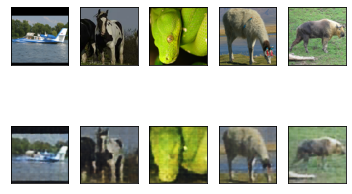

Epoch : [19/50] 

Training Loss: 0.005816	 validation Loss 0.008866
PNSR :16.65 	 SSIM : 0.70
PNSR :13.60 	 SSIM : 0.67
PNSR :14.04 	 SSIM : 0.55
PNSR :20.49 	 SSIM : 0.76
PNSR :18.50 	 SSIM : 0.70


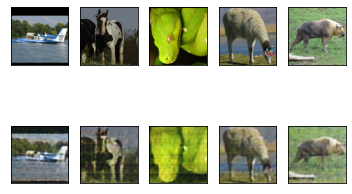

Epoch : [20/50] 

Training Loss: 0.006046	 validation Loss 0.006887
PNSR :18.83 	 SSIM : 0.75
PNSR :15.43 	 SSIM : 0.72
PNSR :16.52 	 SSIM : 0.59
PNSR :21.37 	 SSIM : 0.80
PNSR :18.95 	 SSIM : 0.73


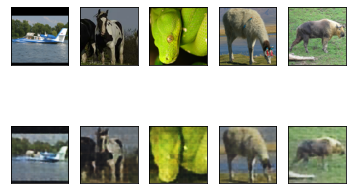

Epoch : [21/50] 

Training Loss: 0.005711	 validation Loss 0.008274
PNSR :17.87 	 SSIM : 0.71
PNSR :15.43 	 SSIM : 0.69
PNSR :16.44 	 SSIM : 0.57
PNSR :20.24 	 SSIM : 0.75
PNSR :18.11 	 SSIM : 0.68


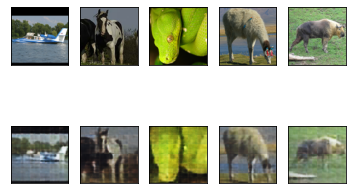

Epoch : [22/50] 

Training Loss: 0.005545	 validation Loss 0.008287
PNSR :17.64 	 SSIM : 0.73
PNSR :14.96 	 SSIM : 0.69
PNSR :17.09 	 SSIM : 0.58
PNSR :20.10 	 SSIM : 0.79
PNSR :18.37 	 SSIM : 0.72


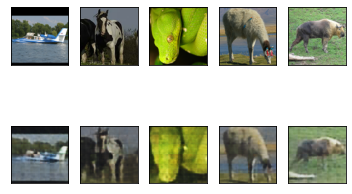

Epoch : [23/50] 

Training Loss: 0.005670	 validation Loss 0.006329
PNSR :19.47 	 SSIM : 0.75
PNSR :16.87 	 SSIM : 0.75
PNSR :17.67 	 SSIM : 0.60
PNSR :20.53 	 SSIM : 0.80
PNSR :19.07 	 SSIM : 0.73


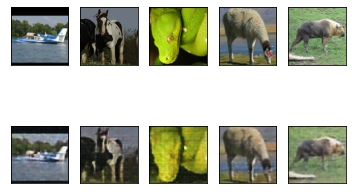

Epoch : [24/50] 

Training Loss: 0.005449	 validation Loss 0.009839
PNSR :17.83 	 SSIM : 0.69
PNSR :16.51 	 SSIM : 0.67
PNSR :16.95 	 SSIM : 0.52
PNSR :17.45 	 SSIM : 0.73
PNSR :15.21 	 SSIM : 0.66


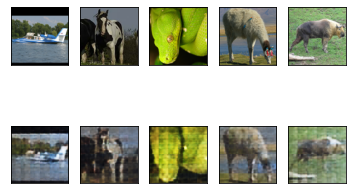

Epoch : [25/50] 

Training Loss: 0.005552	 validation Loss 0.007005
PNSR :17.61 	 SSIM : 0.75
PNSR :15.04 	 SSIM : 0.73
PNSR :16.22 	 SSIM : 0.60
PNSR :21.20 	 SSIM : 0.80
PNSR :18.90 	 SSIM : 0.73


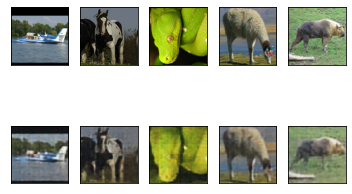

Epoch : [26/50] 

Training Loss: 0.005571	 validation Loss 0.020384
PNSR :12.70 	 SSIM : 0.53
PNSR :6.74 	 SSIM : 0.49
PNSR :14.59 	 SSIM : 0.38
PNSR :17.20 	 SSIM : 0.60
PNSR :11.82 	 SSIM : 0.52


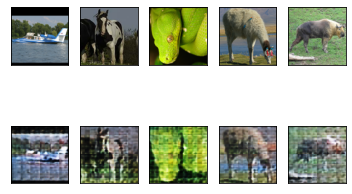

Epoch : [27/50] 

Training Loss: 0.008019	 validation Loss 0.006254
PNSR :20.16 	 SSIM : 0.76
PNSR :16.56 	 SSIM : 0.75
PNSR :19.35 	 SSIM : 0.61
PNSR :21.16 	 SSIM : 0.79
PNSR :18.92 	 SSIM : 0.71


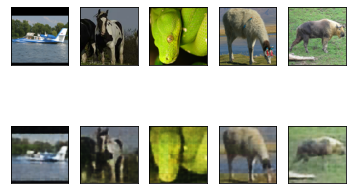

Epoch : [28/50] 

Training Loss: 0.005255	 validation Loss 0.009794
PNSR :16.44 	 SSIM : 0.73
PNSR :14.11 	 SSIM : 0.68
PNSR :15.42 	 SSIM : 0.57
PNSR :19.87 	 SSIM : 0.77
PNSR :17.46 	 SSIM : 0.70


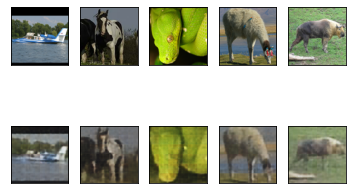

Epoch : [29/50] 

Training Loss: 0.005101	 validation Loss 0.009356
PNSR :16.30 	 SSIM : 0.72
PNSR :13.44 	 SSIM : 0.69
PNSR :14.59 	 SSIM : 0.56
PNSR :20.24 	 SSIM : 0.77
PNSR :17.59 	 SSIM : 0.71


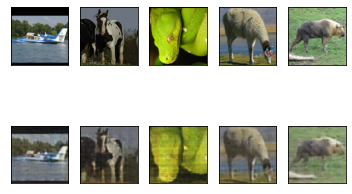

Epoch : [30/50] 

Training Loss: 0.005074	 validation Loss 0.008281
PNSR :17.66 	 SSIM : 0.74
PNSR :14.82 	 SSIM : 0.70
PNSR :16.16 	 SSIM : 0.57
PNSR :20.16 	 SSIM : 0.78
PNSR :17.76 	 SSIM : 0.72


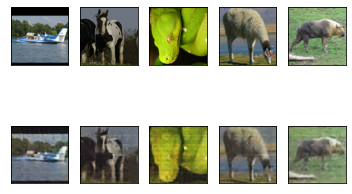

Epoch : [31/50] 

Training Loss: 0.005187	 validation Loss 0.006908
PNSR :18.75 	 SSIM : 0.76
PNSR :15.67 	 SSIM : 0.73
PNSR :17.10 	 SSIM : 0.62
PNSR :21.35 	 SSIM : 0.80
PNSR :18.45 	 SSIM : 0.74


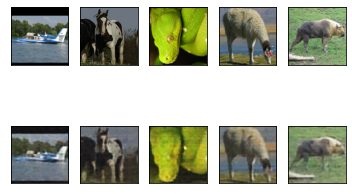

Epoch : [32/50] 

Training Loss: 0.005095	 validation Loss 0.007756
PNSR :18.38 	 SSIM : 0.73
PNSR :15.72 	 SSIM : 0.72
PNSR :16.19 	 SSIM : 0.59
PNSR :20.42 	 SSIM : 0.79
PNSR :18.21 	 SSIM : 0.73


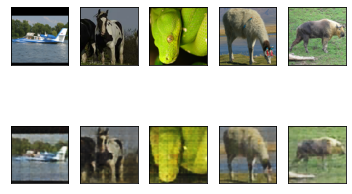

Epoch : [33/50] 

Training Loss: 0.005014	 validation Loss 0.006898
PNSR :19.18 	 SSIM : 0.76
PNSR :16.40 	 SSIM : 0.73
PNSR :18.18 	 SSIM : 0.60
PNSR :20.51 	 SSIM : 0.80
PNSR :18.50 	 SSIM : 0.73


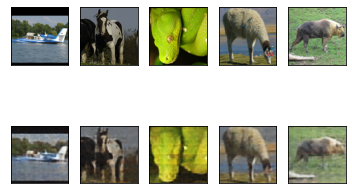

Epoch : [34/50] 

Training Loss: 0.005023	 validation Loss 0.007642
PNSR :18.86 	 SSIM : 0.73
PNSR :15.43 	 SSIM : 0.72
PNSR :17.72 	 SSIM : 0.59
PNSR :20.97 	 SSIM : 0.78
PNSR :18.49 	 SSIM : 0.72


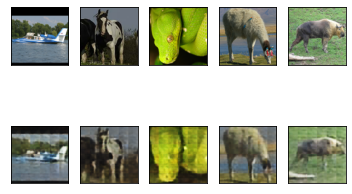

Epoch : [35/50] 

Training Loss: 0.004921	 validation Loss 0.006401
PNSR :18.80 	 SSIM : 0.76
PNSR :16.44 	 SSIM : 0.75
PNSR :17.98 	 SSIM : 0.62
PNSR :21.41 	 SSIM : 0.80
PNSR :19.03 	 SSIM : 0.74


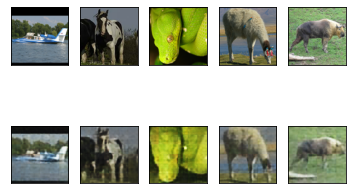

Epoch : [36/50] 

Training Loss: 0.006363	 validation Loss 0.014135
PNSR :16.56 	 SSIM : 0.68
PNSR :15.57 	 SSIM : 0.70
PNSR :17.26 	 SSIM : 0.61
PNSR :16.29 	 SSIM : 0.71
PNSR :14.16 	 SSIM : 0.66


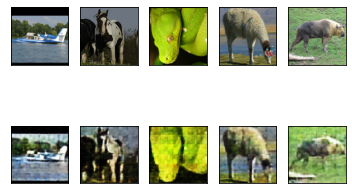

Epoch : [37/50] 

Training Loss: 0.005077	 validation Loss 0.006628
PNSR :19.67 	 SSIM : 0.76
PNSR :16.47 	 SSIM : 0.74
PNSR :16.89 	 SSIM : 0.61
PNSR :20.81 	 SSIM : 0.80
PNSR :18.75 	 SSIM : 0.74


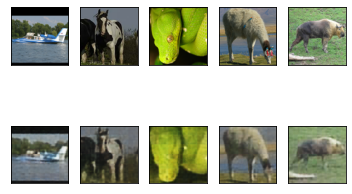

Epoch : [38/50] 

Training Loss: 0.004673	 validation Loss 0.008715
PNSR :17.91 	 SSIM : 0.75
PNSR :14.80 	 SSIM : 0.71
PNSR :15.20 	 SSIM : 0.59
PNSR :20.24 	 SSIM : 0.78
PNSR :18.01 	 SSIM : 0.73


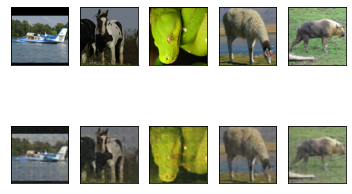

Epoch : [39/50] 

Training Loss: 0.004686	 validation Loss 0.008961
PNSR :17.07 	 SSIM : 0.73
PNSR :14.00 	 SSIM : 0.69
PNSR :14.93 	 SSIM : 0.58
PNSR :19.23 	 SSIM : 0.77
PNSR :17.63 	 SSIM : 0.71


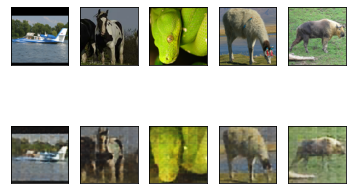

Epoch : [40/50] 

Training Loss: 0.004753	 validation Loss 0.006663
PNSR :18.97 	 SSIM : 0.75
PNSR :16.93 	 SSIM : 0.75
PNSR :20.85 	 SSIM : 0.61
PNSR :19.88 	 SSIM : 0.80
PNSR :18.37 	 SSIM : 0.73


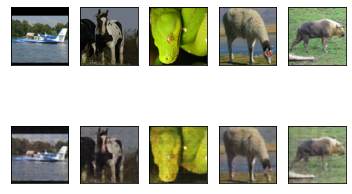

Epoch : [41/50] 

Training Loss: 0.004750	 validation Loss 0.006614
PNSR :19.26 	 SSIM : 0.76
PNSR :16.29 	 SSIM : 0.74
PNSR :18.06 	 SSIM : 0.62
PNSR :20.39 	 SSIM : 0.80
PNSR :19.04 	 SSIM : 0.73


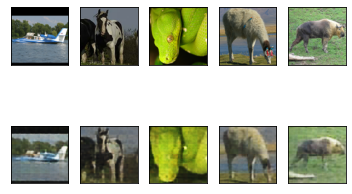

Epoch : [42/50] 

Training Loss: 0.004750	 validation Loss 0.007560
PNSR :18.78 	 SSIM : 0.73
PNSR :16.50 	 SSIM : 0.71
PNSR :18.05 	 SSIM : 0.58
PNSR :19.66 	 SSIM : 0.77
PNSR :17.88 	 SSIM : 0.72


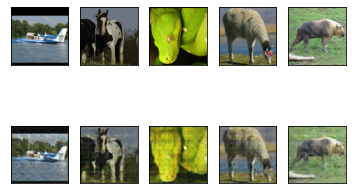

Epoch : [43/50] 

Training Loss: 0.004602	 validation Loss 0.006782
PNSR :19.54 	 SSIM : 0.75
PNSR :16.79 	 SSIM : 0.74
PNSR :18.22 	 SSIM : 0.62
PNSR :20.84 	 SSIM : 0.79
PNSR :18.95 	 SSIM : 0.73


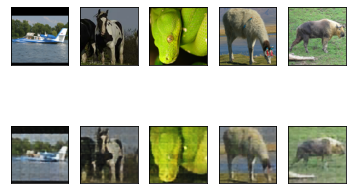

Epoch : [44/50] 

Training Loss: 0.004915	 validation Loss 0.005438
PNSR :20.90 	 SSIM : 0.77
PNSR :16.94 	 SSIM : 0.77
PNSR :18.76 	 SSIM : 0.65
PNSR :21.37 	 SSIM : 0.82
PNSR :19.09 	 SSIM : 0.75


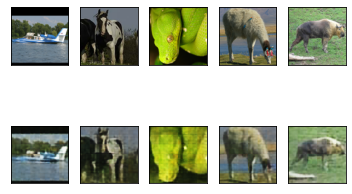

Epoch : [45/50] 

Training Loss: 0.004616	 validation Loss 0.007333
PNSR :18.84 	 SSIM : 0.75
PNSR :16.14 	 SSIM : 0.73
PNSR :15.86 	 SSIM : 0.62
PNSR :20.28 	 SSIM : 0.79
PNSR :18.75 	 SSIM : 0.73


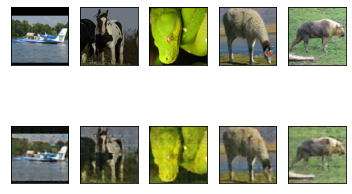

Epoch : [46/50] 

Training Loss: 0.004530	 validation Loss 0.007342
PNSR :19.08 	 SSIM : 0.73
PNSR :16.44 	 SSIM : 0.73
PNSR :19.06 	 SSIM : 0.59
PNSR :20.60 	 SSIM : 0.78
PNSR :18.19 	 SSIM : 0.72


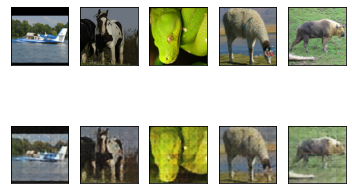

Epoch : [47/50] 

Training Loss: 0.004929	 validation Loss 0.005369
PNSR :19.51 	 SSIM : 0.77
PNSR :17.05 	 SSIM : 0.78
PNSR :18.30 	 SSIM : 0.66
PNSR :21.53 	 SSIM : 0.81
PNSR :18.75 	 SSIM : 0.75


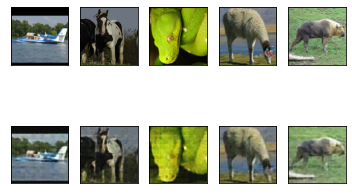

Epoch : [48/50] 

Training Loss: 0.004450	 validation Loss 0.006972
PNSR :18.71 	 SSIM : 0.75
PNSR :15.34 	 SSIM : 0.74
PNSR :19.30 	 SSIM : 0.62
PNSR :20.35 	 SSIM : 0.79
PNSR :18.51 	 SSIM : 0.74


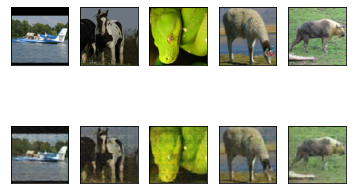

Epoch : [49/50] 

Training Loss: 0.004518	 validation Loss 0.006376
PNSR :19.53 	 SSIM : 0.75
PNSR :16.23 	 SSIM : 0.75
PNSR :18.44 	 SSIM : 0.62
PNSR :20.94 	 SSIM : 0.80
PNSR :18.86 	 SSIM : 0.72


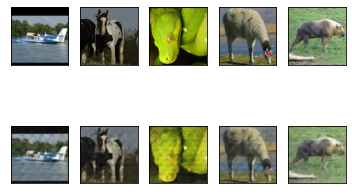

Epoch : [50/50] 

Training Loss: 0.004499	 validation Loss 0.006014
PNSR :20.14 	 SSIM : 0.76
PNSR :17.11 	 SSIM : 0.76
PNSR :19.38 	 SSIM : 0.64
PNSR :20.89 	 SSIM : 0.80
PNSR :19.20 	 SSIM : 0.74


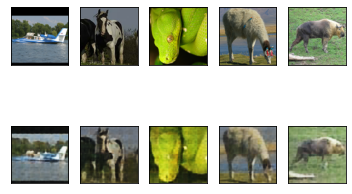

execution time : 29.4min


In [ ]:
n_epochs = 50
#시각화 횟수 설정 
device = get_device()
print(device)

model_strong = Autoencoder()
optimizer_strong = torch.optim.Adam(model_strong.parameters(), lr=0.001, weight_decay  = 1e-04)
model_strong=model_strong.to(device)

strong_train_loss_graph = np.array([]) # 손실 그래프 
strong_val_loss_graph = np.array([])   

start = time.time()

for epoch in range(1, n_epochs+1):
    print(f"Epoch : [{epoch}/{n_epochs}]","\n")

    model_strong.train()
    train_loss = 0.0       #훈련 손실값
    total_train_loss = 0.0 
    val_loss = 0.0         #검증 손실값
    total_val_loss = 0.0

    #훈련
    for i,(tr_img, _) in enumerate(tr_dataloader):

        tr_img = tr_img.to(device)       #입력 이미지
        tr_outputs =model_strong(tr_img) #복원 이미지
        optimizer_strong.zero_grad()

        loss = mse_loss(tr_outputs, tr_img).to(device)
        loss.backward()
        optimizer_strong.step()

        train_loss = loss.clone().detach().item()
        total_train_loss += train_loss

    total_train_loss = total_train_loss/len(tr_dataloader) #평균 훈련 손실값
    strong_train_loss_graph = np.append(strong_train_loss_graph, total_train_loss)

    #검증
    model_strong.eval()
    with torch.no_grad():   
        optimizer_strong.zero_grad()
        
        for i, (val_img, _) in enumerate(val_dataloader):
                val_img = val_img.to(device)
                val_outputs =model_strong(val_img)
                val_loss = mse_loss(val_outputs, val_img)
                val_loss = val_loss.item()
                total_val_loss += val_loss
        total_val_loss = total_val_loss/len(val_dataloader)
        strong_val_loss_graph = np.append(strong_val_loss_graph, total_val_loss)
        print('Training Loss: {:.6f}\t validation Loss {:.6f}'.format(total_train_loss, total_val_loss))
          
        if (epoch)%1 == 0:

          for j in range(5):
            val_ssim = ssim(val_img[j].cpu().numpy().transpose(1, 2, 0), val_outputs[j].cpu().numpy().transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
    
            val_psnr = Get_psnr(val_img[j], val_outputs[j])
            print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(val_psnr,val_ssim))
            
            ax = plt.subplot(2,5,j+1)
            plt.imshow(val_img[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            ax = plt.subplot(2,5,j+5+1)
            plt.imshow(val_outputs[j].cpu().numpy().transpose(1, 2, 0))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

          plt.show()   

end = time.time()

total_time = (end-start)/60
print("execution time : {:.1f}min".format(total_time))

In [ ]:
device = get_device()

file_path = '/content/drive/MyDrive/Colab Notebooks/kodag_5'
names = ['04','10','17','18','19']

model_strong.eval()
data = torchvision.datasets.ImageFolder( root = file_path, transform=transforms.ToTensor() )

for  i in range(5):
    kodag_img = data[i][0].unsqueeze(0).to(device)
    kodag_output = model_strong(kodag_img)
    save_image(kodag_output,'reconstruction_kodag'+names[i]+'.png')
    val_ssim = ssim(kodag_img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0), kodag_output.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0), multichannel=True, gaussian_weights=True, use_sample_covariance=False)
    val_psnr = Get_psnr(kodag_img, kodag_output)
    print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(val_psnr,val_ssim))


PNSR :23.63 	 SSIM : 0.86
PNSR :26.84 	 SSIM : 0.89
PNSR :25.51 	 SSIM : 0.85
PNSR :19.12 	 SSIM : 0.79
PNSR :31.49 	 SSIM : 0.84


In [ ]:
kodag_img.shape # 입력 이미지 차원 크기

torch.Size([1, 3, 768, 512])

In [ ]:
kodag_output.shape # 출력 이미지 차원 크기

torch.Size([1, 3, 768, 512])

In [ ]:
print(kodag_img[0].shape)
print(kodag_output[0].shape)

torch.Size([3, 768, 512])
torch.Size([3, 768, 512])


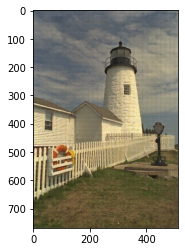

In [ ]:
plt.imshow(kodag_output.detach().cpu().numpy().squeeze(0).transpose(1,2,0))
save_image(kodag_output[0],'reconstruction_kodak19.png')

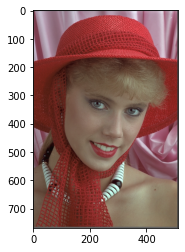

In [ ]:
plt.imshow(kodag_img[0].detach().cpu().numpy().transpose(1,2,0))

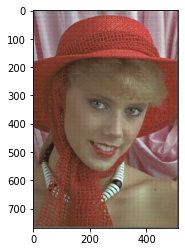

In [ ]:
plt.imshow(kodag_output[0].detach().cpu().numpy().transpose(1,2,0))

In [ ]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model_strong.state_dict():
    print(param_tensor, "\t", model_strong.state_dict()[param_tensor].size())

# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer_strong.state_dict():
    print(var_name, "\t", optimizer_strong.state_dict()[var_name])

## test graph for (average psnr, ssim) 미완성

In [ ]:
#TODO. 복원 이미지 그래프 그리기

from skimage.metrics import structural_similarity as ssim

sum_ssim = 0.0
sum_psnr = 0.0
avg_ssim = 0.0
avg_psnr = 0.0

model_strong.eval()
with torch.no_grad():
    optimizer_strong.zero_grad()
    for i, (test_img, hat_test_img) in enumerate(zip(test_dataloader, Gs_blur_strong_test_dataloader)):
        
        strong_test_img, _ = test_img
        strong_test_img = strong_test_img.to(device)
        strong_test_hat_img, _ = hat_test_img
        strong_test_hat_img = strong_test_hat_img.to(device)

        test_outputs = model_strong(strong_test_hat_img)
        
    for j in range(10):
        img1_cpu = strong_test_img[j].cpu().numpy().transpose(1, 2, 0)
        img1_float64 = img1_cpu.astype(np.float64)
        img2_cpu = test_outputs[j].cpu().numpy()
        img2_float64 = img2_cpu.astype(np.float64).transpose(1, 2, 0)
        
        strong_ssim = ssim(img1_float64, img2_float64, multichannel=True, gaussian_weights=True)
        strong_psnr = Get_psnr(strong_test_img[j], test_outputs[j], max_val = 1.0)
        sum_psnr+=strong_psnr
        sum_ssim+=strong_ssim
        print('PNSR :{:.2f} \t SSIM : {:.2f}'.format(strong_psnr,strong_ssim))
        
        ax = plt.subplot(3,10,j+1)
        plt.imshow(strong_test_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10,j+10+1)
        plt.imshow(strong_test_hat_img[j].cpu().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


        ax = plt.subplot(3,10, j+20+1)
        plt.imshow(test_outputs[j].cpu().detach().numpy().transpose(1, 2, 0))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()   
avg_psnr=sum_psnr/10
avg_ssim=sum_ssim/10

print("avg_psnr : {:.2f}".format(avg_psnr))
print("avg_ssim : {:.2f}".format(avg_ssim))
